# Linear Frequency-Dependent PTO 

In [1]:
import os
import logging

import matplotlib.pyplot as plt
import capytaine as cpy
from autograd.builtins import isinstance, tuple, list, dict
import autograd.numpy as np
import xarray as xr

import wecopttool as wot


# logging 
logging.basicConfig(level=logging.INFO)

# create save directory
results_dir = 'results_linear_freqdep_pto'
if not os.path.exists(results_dir):
  os.makedirs(results_dir)

# frequencies
f0 = 0.05
nfreq = 50

### WEC

In [2]:
## WEC object
# mesh
wb = wot.geom.WaveBot() 
mesh_size_factor = 0.5 
mesh = wb.mesh(mesh_size_factor)

# floating body
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="HEAVE")

# hydrostatics
hs_data = wot.hydrostatics.hydrostatics(fb)
mass_33 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 2]
mass = np.atleast_2d(mass_33)
stiffness_33 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 2]
stiffness = np.atleast_2d(stiffness_33)

# WEC object
wec = wot.WEC(fb, mass, stiffness, f0, nfreq)

# BEM
fname = os.path.join(results_dir, 'bem.nc')
if os.path.exists(fname):
    wec.read_bem(fname)
else:
    wec.run_bem()
    wec.write_bem(fname)

INFO:capytaine.bodies.bodies:Stored 1054 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:Changing value of 'f_add'. This might cause some attributes to be reset.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Reading BEM data from results_linear_freqdep_pto/bem.nc.
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Calculating impedance matrix.
INFO:capytaine.post_pro.impedance:Compute impedance.


### PTO

In [3]:
# PTO kinematics
kinematics = np.eye(fb.nb_dofs)

# PTO impedance - frequency dependent
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0 
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*wec.omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        -1/(1j*wec.omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*wec.omega*winding_inductance

pto_impedance_11 = gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = (off_diag+0j) * np.ones(wec.omega.shape) 
pto_impedance_21 = pto_impedance_12
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                          [pto_impedance_21, pto_impedance_22]])

# create PTO
pto = wot.pto.PILinearPTO(nfreq, kinematics, pto_impedance)

# add PTO force to WEC
wec.f_add = pto.force_on_wec

INFO:wecopttool.core:Changing value of 'f_add'. This might cause some attributes to be reset.


### Waves

In [4]:
# waves
wfreq = 0.3
amplitude = 0.0625
phase = -40
waves = wot.waves.regular_wave(f0, nfreq, wfreq, amplitude, phase)

### Objective Function

In [5]:
# objective function
obj_fun = pto.electric_average_power
nstate_opt = pto.nstate

### Solve

In [6]:
# solve
scale_x_wec = 1.0
scale_x_opt = 0.01
scale_obj = 1.0

options = {'maxiter': 100, 'ftol': 1e-8}

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

# post-process
pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)


INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.03e+02, 1.94e+05, 4.11e+21]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.63e+01, 2.31e+04, 1.13e+15]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.33e-01, 3.82e+02, 5.28e+07]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.84e-01, 3.13e+03, 1.67e+11]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.01e+00, 8.13e+03, 6.90e+12]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.04e+00, 1.46e+03, 1.14e+10]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.00e-01, 5.60e+02, 3.81e+08]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.59e-01, 2.10e+02, 1.89e+08]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.83e-01, 2.57e+02, 7.30e+07]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.52e-03, 2.95e+02, 2.25e+07]
INFO:wecopttool.co

Iteration limit reached    (Exit mode 9)
            Current function value: 16.727587838228086
            Iterations: 100
            Function evaluations: 394
            Gradient evaluations: 100


### CC (Electrical) Solution


In [7]:
Z_11 = pto_impedance[0, 0, :]
Z_12 = pto_impedance[0, 1, :]
Z_21 = pto_impedance[1, 0, :]
Z_22 = pto_impedance[1, 1, :]

idof = 0
Fe = wec_fdom['excitation_force'][1:, idof]
Zi = wec.hydro.Zi[:, idof, idof]

V_th = Z_21 / (Z_11 - Zi) * Fe
Z_th = Z_22 - (Z_12*Z_21) / (Z_11 - Zi)

cc_current_fd = V_th / (2*Z_th.real)
cc_voltage_fd = -1.0 * Z_th.conj() * cc_current_fd

cc_current_td = wot.post_process_continuous_time(cc_current_fd)
cc_voltage_td = wot.post_process_continuous_time(cc_voltage_fd)

In [8]:
# Mechanical quantities
cc_velocity_fd = np.zeros(nfreq) *0j
cc_force_fd = np.zeros(nfreq) * 0j

for ifreq in range(nfreq):
    abc_inv = np.linalg.inv(pto._impedance_abc[:, :, ifreq])
    vec_elec = np.array([[cc_current_fd[ifreq]], [cc_voltage_fd[ifreq]]])
    vec_mech = abc_inv @ vec_elec
    cc_velocity_fd[ifreq] = vec_mech[0, 0]
    cc_force_fd[ifreq] = vec_mech[1, 0]

cc_velocity_fd = xr.DataArray(
    cc_velocity_fd, dims=["omega"], coords=[("omega", wec.omega),],)
cc_force_fd = xr.DataArray(
    cc_force_fd, dims=["omega"], coords=[("omega", wec.omega), ],)

cc_velocity_td = wot.post_process_continuous_time(cc_velocity_fd)
cc_force_td = wot.post_process_continuous_time(cc_force_fd)


### Compare Results to CC

Text(0, 0.5, 'electrical power [W]')

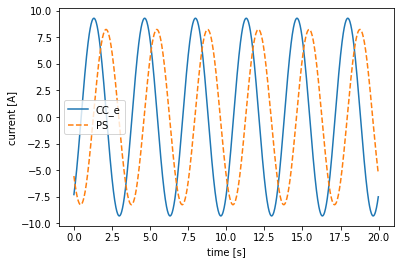

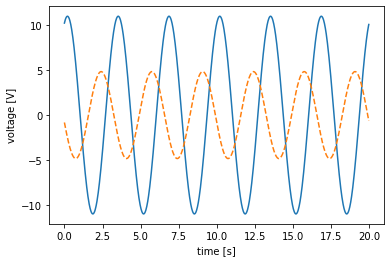

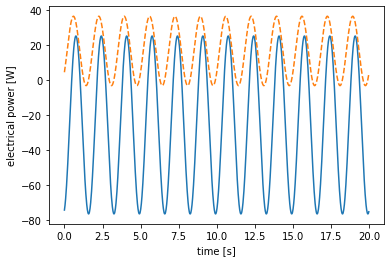

In [9]:
nsubsteps = 10
t = wec.make_time_vec(nsubsteps)

# plot electrical power
plt.figure()
plt.plot(t, cc_current_td(t), '-', label='CC_e')
plt.plot(t, pto.electric_current(
    wec, x_wec, x_opt, nsubsteps), '--', label='PS')
plt.xlabel('time [s]')
plt.ylabel('current [A]')
plt.legend()

plt.figure()
plt.plot(t, cc_voltage_td(t), '-')
plt.plot(t, pto.electric_voltage(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('voltage [V]')

plt.figure()
plt.plot(t, cc_current_td(t)*cc_voltage_td(t), '-')
plt.plot(t, pto.electric_power(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('electrical power [W]')

Text(0, 0.5, 'mechanical power [W]')

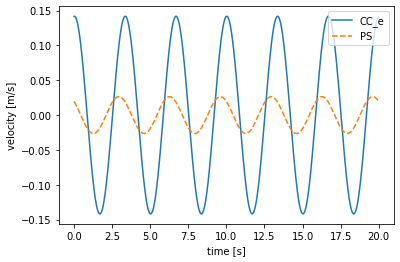

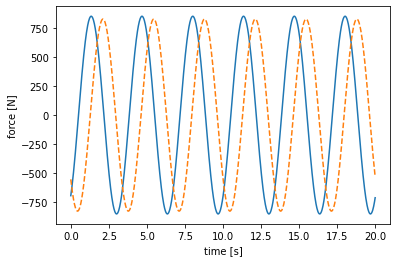

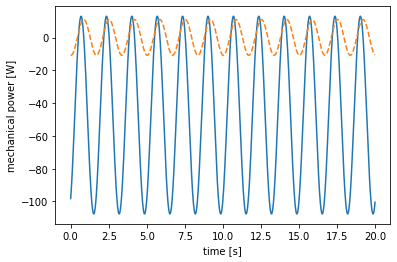

In [10]:
# plot mechanical power
plt.figure()
plt.plot(t, cc_velocity_td(t), '-', label='CC_e')
plt.plot(t, pto.velocity(
    wec, x_wec, x_opt, nsubsteps), '--', label='PS')
plt.xlabel('time [s]')
plt.ylabel('velocity [m/s]')
plt.legend()

plt.figure()
plt.plot(t, cc_force_td(t), '-')
plt.plot(t, pto.force(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('force [N]')

plt.figure()
plt.plot(t, cc_velocity_td(t)*cc_force_td(t), '-')
plt.plot(t, pto.power(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('mechanical power [W]')


### DEBUG

In [11]:
current, voltage = pto._split_vars(pto._calc_elec_vars(pto._calc_mech_vars(wec, x_wec, x_opt)))

In [12]:
current_org = np.array([-2.23262528e-09, -1.38802751e-09,  5.83283764e-10,  8.34197222e-10,
               -6.98708015e-10,  4.96258703e-10,  6.32534499e-10,  1.92486935e-09,
               -7.78939655e-11, -2.00941245e-10, -7.28464192e+00,  5.76695312e+00,
               -5.64647860e-10, -6.95386493e-10, -2.91527426e-10,  3.95616626e-11,
               -1.46869315e-09, -1.24686976e-09, -1.19394600e-09, -6.94663056e-10,
               -1.09286433e-10, -4.50982202e-10, -4.74777932e-11,  2.57805599e-11,
               -3.36323966e-11,  8.14689671e-12, -2.99382476e-10, -5.17017231e-12,
               8.69863143e-11,  3.14535146e-11,  6.06300264e-11, -8.83657747e-11,
               4.23170919e-10, -9.26091062e-10,  6.61130213e-10, -6.10000486e-10,
               -3.58568994e-10, -1.36338596e-09,  1.93899001e-10, -8.85195206e-10,
               -7.89266025e-10, -2.56747878e-10, -2.36981409e-09,  2.00505895e-09,
               -3.20745930e-09, -3.96583350e-09,  4.94392410e-09, -3.37979644e-10,
               -2.92523077e-08, -3.47532693e-07,  7.28495070e-09,  9.49893384e-10,
               2.02338003e-07,  1.82424688e-07,  5.60452025e-07, -7.84848447e-07,
               4.24700675e-09, -2.56450170e-07, -4.43364996e-08, -4.80702817e-08,
               -1.63106858e-08, -9.97650888e-09, -1.36738326e-07,  1.65779743e-07,
               8.86737321e-08, -3.61964967e-08, -5.57852523e-08,  2.48108568e-08,
               -2.26740921e-07, -2.43714122e-07,  1.80573195e-08, -1.21431174e-07,
               5.03916026e-09,  2.31151179e-07,  3.03432480e-07,  1.92047984e-07,
               1.16240306e-07,  4.87437895e-08, -1.30430428e-07, -1.01739470e-07,
               -1.11780324e-07,  6.98587712e-08, -7.90978944e-09,  5.52204416e-07,
               1.62020597e-08,  3.28549060e-08,  5.82117372e-07,  3.70230040e-07,
               7.48761562e-09, -2.09133939e-07, -1.39245430e-07,  2.31977091e-07,
               8.95824148e-08,  1.13704723e-09,  2.33712394e-08,  1.55698581e-07,
               1.84449871e-07,  3.52957042e-07,  3.37469204e-07, -7.70831788e-07])


In [13]:
np.max(current), np.min(current)

(1.918063053379974e-06, -6.095974915052279)

In [14]:
np.max(current_org), np.min(current_org)

(5.76695312, -7.28464192)

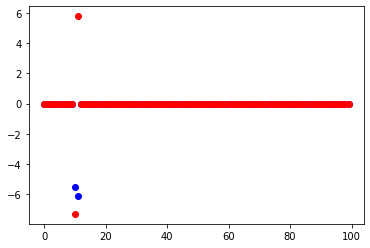

In [15]:
plt.figure()
plt.plot(current, 'bo')
plt.plot(current_org, 'ro')

In [16]:
ind = int(np.where(np.isclose(wec.freq, wfreq))[0])

i_opt = cc_current_fd.values[ind]
V_opt = cc_voltage_fd.values[ind]

Z_Fu = pto.impedance[0, 0, ind]
Z_Fi = pto.impedance[0, 1, ind]
Z_Vu = pto.impedance[1, 0, ind]
Z_Vi = pto.impedance[1, 1, ind]

D_abc = Z_Vu + (Z_Vi - 1)*(Z_Fu/Z_Fi)

u_opt = -Z_Vi/D_abc * i_opt + V_opt/D_abc
F_opt = (Z_Fi - Z_Fu*Z_Vi/D_abc) * i_opt + V_opt/D_abc*Z_Fu

C_opt = F_opt / u_opt
(-np.imag(C_opt)*wec.omega[ind], np.real(C_opt))

(7005.571061331491, -4694.268133981681)

In [17]:
x_opt

array([-58857.36633281,    327.96776844])

In [18]:
tmp = cc_force_fd / cc_velocity_fd
tmp = tmp.values[ind]
(-np.imag(tmp)*wec.omega[ind], np.real(tmp))

(7005.571061331491, -4694.268133981681)

### sympy

In [19]:
import sympy

j = sympy.symbols('j')

# Zi
Zi_r, Zi_i = sympy.symbols("Zi_r Zi_i", real=True)
Zi = Zi_r + j*Zi_r

# Fe
Fe_r, Fe_i = sympy.symbols("Fe_r Fe_i", real=True)
Fe = Fe_r + j*Fe_i

# Z_Fu
Zfu_r, Zfu_i = sympy.symbols("Zfu_r Zfu_i", real=True)
Zfu = Zfu_r + j*Zfu_i

# Z_Fi
Zfi_r, Zfi_i = sympy.symbols("Zfi_r Zfi_i", real=True)
Zfi = Zfi_r + j*Zfi_i

# Z_Vu
Zvu_r, Zvu_i = sympy.symbols("Zvu_r Zvu_i", real=True)
Zvu = Zvu_r + j*Zvu_i

# Z_Vi
Zvi_r, Zvi_i = sympy.symbols("Zvi_r Zvi_i", real=True)
Zvi = Zvi_r + j*Zvi_i

Dabc = Zvu + ((Zvi - 1)*(Zfu / Zfi))

Vth = Zvu / (Zfu-Zi) *Fe
Zth = Zvi - (Zfi*Zvu)/(Zfu-Zi)

In [20]:
n, dd = sympy.factor(Zth, j).subs(j**2, -1).as_numer_denom()

In [21]:
dd.args

(Zfu_r, -Zi_r, j*(Zfu_i - Zi_r))

In [22]:
b = n.args[3]/j
a = n.args[0] + n.args[1] + n.args[2]
for ia in n.args[4:]:
    a += ia
c = dd.args[0] + dd.args[1]
d = dd.args[2]/j

Zth_r = (a*c + b*d) / (c**2 + d**2)
Zth_i = (b*c - a*d) / (c**2 + d**2)
Zth = Zth_r + j*Zth_i

Iopt = Vth / (2*Zth_r)
Vopt = (-Zth_r + j*Zth_i)*Iopt

Uopt = -Zvi/Dabc*Iopt + Vopt/Dabc
Fopt = (Zfi -Zfu/Dabc*Zvi)*Iopt + Zfu/Dabc*Vopt
C = Fopt/Uopt

In [23]:
n, dd = sympy.factor(C, j).subs(j**2, -1).as_numer_denom()

In [24]:
dd.args

(j*(Zfi_i*Zfu_i*Zvu_i + Zfi_i*Zfu_r*Zvu_r - Zfi_i*Zi_r*Zvu_i - Zfi_i*Zi_r*Zvu_r - Zfi_r*Zfu_i*Zvu_r + Zfi_r*Zfu_r*Zvu_i - Zfi_r*Zi_r*Zvu_i + Zfi_r*Zi_r*Zvu_r),
 2*Zfu_i**2*Zvi_r,
 2*Zfu_r**2*Zvi_r,
 4*Zi_r**2*Zvi_r,
 Zfi_i*Zfu_r*Zvu_i,
 Zfi_i*Zi_r*Zvu_r,
 Zfi_r*Zi_r*Zvu_i,
 Zfi_r*Zi_r*Zvu_r,
 -Zfi_i*Zfu_i*Zvu_r,
 -Zfi_i*Zi_r*Zvu_i,
 -Zfi_r*Zfu_i*Zvu_i,
 -Zfi_r*Zfu_r*Zvu_r,
 -4*Zfu_i*Zi_r*Zvi_r,
 -4*Zfu_r*Zi_r*Zvi_r)

In [25]:
b = n.args[1]/j
a = n.args[0]
for ia in n.args[2:]:
    a += ia

d = dd.args[0]/j
c = dd.args[1]
for id in dd.args[2:]:
    c += id

C_r = (a*c + b*d) / (c**2 + d**2)
C_i = (b*c - a*d) / (c**2 + d**2)


In [26]:
sympy.simplify(C_r)

((Zfi_i*Zfu_i*Zvu_i + Zfi_i*Zfu_r*Zvu_r - Zfi_i*Zi_r*Zvu_i - Zfi_i*Zi_r*Zvu_r - Zfi_r*Zfu_i*Zvu_r + Zfi_r*Zfu_r*Zvu_i - Zfi_r*Zi_r*Zvu_i + Zfi_r*Zi_r*Zvu_r)*(-2*Zfi_i*Zfu_i**2*Zvu_r + 2*Zfi_i*Zfu_i*Zfu_r*Zvu_i - Zfi_i*Zfu_i*Zi_r*Zvu_i + 3*Zfi_i*Zfu_i*Zi_r*Zvu_r - Zfi_i*Zfu_r*Zi_r*Zvu_i + Zfi_i*Zfu_r*Zi_r*Zvu_r - 2*Zfi_i*Zi_r**2*Zvu_r - 2*Zfi_r*Zfu_i**2*Zvu_i - 2*Zfi_r*Zfu_i*Zfu_r*Zvu_r + 3*Zfi_r*Zfu_i*Zi_r*Zvu_i + Zfi_r*Zfu_i*Zi_r*Zvu_r + Zfi_r*Zfu_r*Zi_r*Zvu_i + Zfi_r*Zfu_r*Zi_r*Zvu_r - 2*Zfi_r*Zi_r**2*Zvu_i + Zfu_i**3*Zvi_r + Zfu_i**3 - Zfu_i**2*Zfu_r*Zvi_i - 2*Zfu_i**2*Zi_r*Zvi_r - 2*Zfu_i**2*Zi_r + Zfu_i*Zfu_r**2*Zvi_r + Zfu_i*Zfu_r**2 + 2*Zfu_i*Zfu_r*Zi_r*Zvi_i - 2*Zfu_i*Zfu_r*Zi_r*Zvi_r - 2*Zfu_i*Zfu_r*Zi_r + 2*Zfu_i*Zi_r**2*Zvi_r + 2*Zfu_i*Zi_r**2 - Zfu_r**3*Zvi_i + 2*Zfu_r**2*Zi_r*Zvi_i - 2*Zfu_r*Zi_r**2*Zvi_i) + (-Zfi_i*Zfu_i*Zvu_r + Zfi_i*Zfu_r*Zvu_i - Zfi_i*Zi_r*Zvu_i + Zfi_i*Zi_r*Zvu_r - Zfi_r*Zfu_i*Zvu_i - Zfi_r*Zfu_r*Zvu_r + Zfi_r*Zi_r*Zvu_i + Zfi_r*Zi_r*Zvu_r + 2*Zfu_i**

In [27]:
sympy.simplify(C_i)

(-(Zfi_i*Zfu_i*Zvu_i + Zfi_i*Zfu_r*Zvu_r - Zfi_i*Zi_r*Zvu_i - Zfi_i*Zi_r*Zvu_r - Zfi_r*Zfu_i*Zvu_r + Zfi_r*Zfu_r*Zvu_i - Zfi_r*Zi_r*Zvu_i + Zfi_r*Zi_r*Zvu_r)*(-2*Zfi_i*Zfu_i*Zfu_r*Zvu_r - Zfi_i*Zfu_i*Zi_r*Zvu_i + Zfi_i*Zfu_i*Zi_r*Zvu_r + 2*Zfi_i*Zfu_r**2*Zvu_i - 3*Zfi_i*Zfu_r*Zi_r*Zvu_i + Zfi_i*Zfu_r*Zi_r*Zvu_r + 2*Zfi_i*Zi_r**2*Zvu_i - 2*Zfi_r*Zfu_i*Zfu_r*Zvu_i + Zfi_r*Zfu_i*Zi_r*Zvu_i + Zfi_r*Zfu_i*Zi_r*Zvu_r - 2*Zfi_r*Zfu_r**2*Zvu_r + Zfi_r*Zfu_r*Zi_r*Zvu_i + 3*Zfi_r*Zfu_r*Zi_r*Zvu_r - 2*Zfi_r*Zi_r**2*Zvu_r + Zfu_i**3*Zvi_i + Zfu_i**2*Zfu_r*Zvi_r + Zfu_i**2*Zfu_r - 2*Zfu_i**2*Zi_r*Zvi_i + Zfu_i*Zfu_r**2*Zvi_i - 2*Zfu_i*Zfu_r*Zi_r*Zvi_i - 2*Zfu_i*Zfu_r*Zi_r*Zvi_r - 2*Zfu_i*Zfu_r*Zi_r + 2*Zfu_i*Zi_r**2*Zvi_i + Zfu_r**3*Zvi_r + Zfu_r**3 - 2*Zfu_r**2*Zi_r*Zvi_r - 2*Zfu_r**2*Zi_r + 2*Zfu_r*Zi_r**2*Zvi_r + 2*Zfu_r*Zi_r**2) + (-Zfi_i*Zfu_i*Zvu_r + Zfi_i*Zfu_r*Zvu_i - Zfi_i*Zi_r*Zvu_i + Zfi_i*Zi_r*Zvu_r - Zfi_r*Zfu_i*Zvu_i - Zfi_r*Zfu_r*Zvu_r + Zfi_r*Zi_r*Zvu_i + Zfi_r*Zi_r*Zvu_r + 2*Zfu_i*

In [28]:
# Zi
vZi = wec.hydro.Zi.values[ind,0,0]
vZi_r = np.real(vZi)
vZi_i = np.imag(vZi)
vC_i = C_i.subs(Zi_r, vZi_r).subs(Zi_i, vZi_i)
vC_r = C_r.subs(Zi_r, vZi_r).subs(Zi_i, vZi_i)

# Fe
vFe = wec_fdom["excitation_force"].values[ind+1]
vFe_r = np.real(vFe)
vFe_i = np.imag(vFe)
vC_i = vC_i.subs(Fe_r, vFe_r).subs(Fe_i, vFe_i)
vC_r = vC_r.subs(Fe_r, vFe_r).subs(Fe_i, vFe_i)

# Z_Fu
vZfu = pto.impedance[0, 0, ind]
vZfu_r = np.real(vZfu)
vZfu_i = np.imag(vZfu)
vC_i = vC_i.subs(Zfu_r, vZfu_r).subs(Zfu_i, vZfu_i)
vC_r = vC_r.subs(Zfu_r, vZfu_r).subs(Zfu_i, vZfu_i)

# Z_Fi
vZfi = pto.impedance[0, 1, ind]
vZfi_r = np.real(vZfi)
vZfi_i = np.imag(vZfi)
vC_i = vC_i.subs(Zfi_r, vZfi_r).subs(Zfi_i, vZfi_i)
vC_r = vC_r.subs(Zfi_r, vZfi_r).subs(Zfi_i, vZfi_i)

# Z_Vu
vZvu = pto.impedance[1, 0, ind]
vZvu_r = np.real(vZvu)
vZvu_i = np.imag(vZvu)
vC_i = vC_i.subs(Zvu_r, vZvu_r).subs(Zvu_i, vZvu_i)
vC_r = vC_r.subs(Zvu_r, vZvu_r).subs(Zvu_i, vZvu_i)

# Z_Vi
vZvi = pto.impedance[1, 1, ind]
vZvi_r = np.real(vZvi)
vZvi_i = np.imag(vZvi)
vC_i = vC_i.subs(Zvi_r, vZvi_r).subs(Zvi_i, vZvi_i)
vC_r = vC_r.subs(Zvi_r, vZvi_r).subs(Zvi_i, vZvi_i)

In [29]:
(vC_i, vC_r)

(951.673286573831, -646.921506300399)

In [30]:
(-vC_i*wec.omega[ind], vC_r)

(-1793.86188343080, -646.921506300399)